<h2 align=center> Toxic Comments Classification using 1D CNN with Keras</h2>

### Task 1: Import Packages and Functions

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding,LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import re
from keras.optimizers import Adam
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
print(tf.__version__)

2.4.1


### Task 2: Load and Explore Data

In [ ]:
# Load data
review=pd.read_csv('/content/reviews.csv',header=None,names=['reviews'])
meta=pd.read_csv('/content/metadata.csv',usecols=['SENTIMENT','TOPIC'])
meta.columns = ['sentiment', 'topic']
meta

,sentiment,topic
0,neg,A restaurant
1,neg,A movie
2,neg,A restaurant
3,neg,A movie
4,pos,A book
...,...,...
1239,neg,A movie
1240,neg,A movie
1241,pos,A restaurant
1242,neg,A restaurant


In [ ]:
task1_df = pd.DataFrame([review.reviews, meta.sentiment]).transpose()
#task1_df=task1_df.dropna(subset=['topic'])
task1_df['sentiment'] = (task1_df['sentiment'] == 'pos').astype(int)
task1_df

,reviews,sentiment
0,i did not enjoy the japanese restaurant on par...,0
1,batman v superman oh my god what an abysmal mo...,0
2,i went to a restaurant down the street and had...,0
3,the star wars the rise of skywalker 2 out of 5...,0
4,it was a very engaging book that was very easy...,1
...,...,...
1239,bad moms is a hyperbolic romantic comedy that ...,0
1240,i didn t understand the point of once upon a t...,0
1241,recently my wife and i shared a meal together ...,1
1242,it is not difficult to find pio pio in the lis...,0


In [ ]:
x= task1_df['reviews'].values
cv = CountVectorizer(min_df=0.05, max_df=0.95,stop_words='english') 
X = cv.fit_transform(x)


In [ ]:
x= task1_df['reviews'].values


### Task 3- View few positive comments


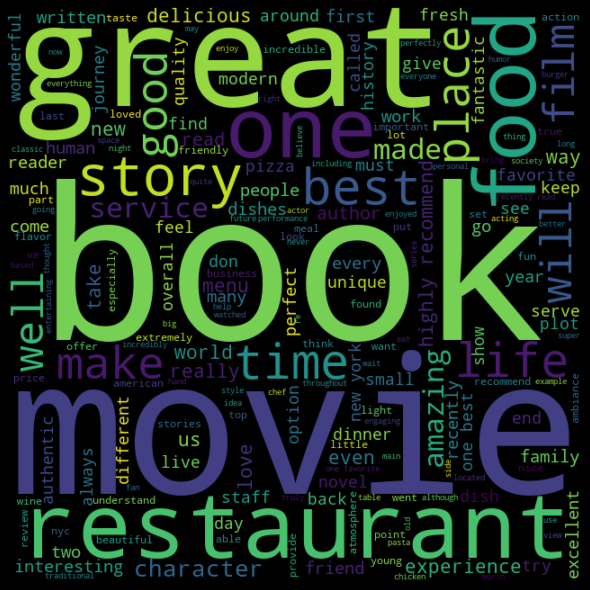

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
comments = task1_df['reviews'].loc[task1_df['sentiment']==1].values
wordcloud = WordCloud(
    width = 640,
    height = 640,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(comments))
fig = plt.figure(
    figsize = (12, 8),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
y=task1_df['sentiment'].values.astype(int)
task1_df['sentiment'].value_counts()


1    623
0    621
Name: sentiment, dtype: int64

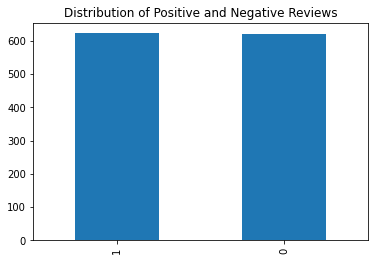

In [ ]:
# Plot frequency of toxic comments
task1_df['sentiment'].value_counts().plot(kind='bar', title='Distribution of Positive and Negative Reviews')



### Task 4: Data Prep — Tokenize and Pad Text Data

In [ ]:
max_features=20000
max_text_len=400
embedding_dim = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
filters=128
kernel_size=5
hidden_dims=24


In [ ]:
tokenizer=text.Tokenizer(max_features, oov_token=oov_tok)
tokenizer.fit_on_texts(list(x))
word_index = tokenizer.word_index
tokenized=tokenizer.texts_to_sequences(x)
seq=sequence.pad_sequences(tokenized,maxlen=max_text_len, padding=padding_type, truncating=trunc_type)


### Task 5: Create the Embedding Layer

In [ ]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim, input_length=max_text_len))
model.add(Bidirectional(LSTM(64, dropout=0.4, recurrent_dropout=0.2)))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.50))
model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(loss='binary_crossentropy',optimizer=Adam(0.001),metrics=['accuracy'])

### Task 7: Train Model

In [ ]:
X_train,X_val,y_train,y_val=train_test_split(seq,y,test_size=0.5,random_state=0)

In [ ]:
batch_size=64
early=EarlyStopping(monitor='val_loss',patience=6,mode='min')
checkpoint = ModelCheckpoint("model.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)

reduce_lor = ReduceLROnPlateau(monitor = 'val_accuracy', 
                               mode='max',
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1)
hist=model.fit(X_train,y_train,batch_size=batch_size,epochs=30,validation_data=(X_val,y_val),callbacks=[checkpoint,early,reduce_lor])

Epoch 1/30
10/10 [==============================] - 32s 3s/step - loss: 0.6939 - accuracy: 0.4834 - val_loss: 0.6924 - val_accuracy: 0.5756

Epoch 00001: val_accuracy improved from -inf to 0.57556, saving model to model.h5
Epoch 2/30
10/10 [==============================] - 28s 3s/step - loss: 0.6890 - accuracy: 0.5864 - val_loss: 0.6784 - val_accuracy: 0.6463

Epoch 00002: val_accuracy improved from 0.57556 to 0.64630, saving model to model.h5
Epoch 3/30
10/10 [==============================] - 28s 3s/step - loss: 0.6158 - accuracy: 0.7503 - val_loss: 0.5708 - val_accuracy: 0.7235

Epoch 00003: val_accuracy improved from 0.64630 to 0.72347, saving model to model.h5
Epoch 4/30
10/10 [==============================] - 28s 3s/step - loss: 0.2746 - accuracy: 0.9090 - val_loss: 0.5416 - val_accuracy: 0.8119

Epoch 00004: val_accuracy improved from 0.72347 to 0.81190, saving model to model.h5
Epoch 5/30
10/10 [==============================] - 28s 3s/step - loss: 0.0307 - accuracy: 0.9927 -

In [ ]:
from keras.models import load_model
model=load_model('model.h5')
model.save('sentiment_analysis.h5')

### Task-8 Plot accuracy vs epoch and loss vs epoch

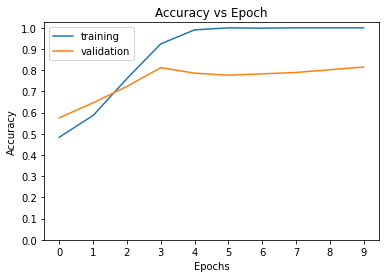

In [ ]:
epochs = range(len(hist.history['accuracy']))
plt.plot(epochs,hist.history['accuracy'],label='training')
plt.plot(epochs,hist.history['val_accuracy'],label='validation')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.xticks(range(len(hist.history['accuracy'])))
plt.yticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1])
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()

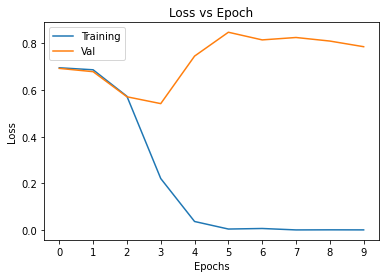

In [ ]:
epochs = range(len(hist.history['accuracy']))
plt.plot(epochs,hist.history['loss'],label='Training')
plt.plot(epochs,hist.history['val_loss'],label='Val')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.xticks(range(len(hist.history['accuracy'])))
plt.title('Loss vs Epoch')
plt.legend()
plt.show()

### Task 9: Evaluate Model

In [ ]:
model.evaluate(X_val,y_val)

20/20 [==============================] - 4s 170ms/step - loss: 0.7853 - accuracy: 0.8151


[0.7853459715843201, 0.8151125311851501]

### Task 10- Make predictions

In [ ]:
s=input("Enter your string:  ")
s=np.array([s])
tokenized=tokenizer.texts_to_sequences(s)
X_test=sequence.pad_sequences(tokenized,maxlen=max_text_len, padding=padding_type, truncating=trunc_type)
y_test=model.predict(X_test,verbose=1,batch_size=128)
val=['neg' if x < .5 else 'pos' for x in y_test]
print(s[0],'-',val[0])

Enter your string:  That was such an amazing movie
1/1 [==============================] - 0s 176ms/step
That was such an amazing movie - pos
